<a target="_blank" href="https://colab.research.google.com/github/dahenderson98/FineTuning/blob/main/finetuning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#Transfer Learning/Fine-Tuning

## Description

### Objective

- Gain experience fine-tuning pre-trained models to domain-specific applications.

### Deliverable

For this lab you will submit an ipython notebook via learning suite. The bulk of the work is in modifying fine-tuning a pre-trained ResNet. Fine-tuning the GPT-2 language model is pretty easy. The provided code works as is; you will just have to swap in your own text dataset.

### Grading

- 35% Create a dataset class for your own dataset
- 35% Create a network class that wraps a pretrained ResNet
- 20% Implement unfreezing in the network class
- 10% Fine-tune GPT-2 on your own dataset

### Tips
- Your life will be better if you download a dataset that already has the data in the expected format for ImageFolder (make sure to read the documentation!). The datasets recommended below are in the correct format.
- Get the CNN working on the provided dataset (bird species classification) before swapping in your own.
- For reference on freezing/unfreezing network weights, see [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c)
- For training GPT-2, first try the medium-size (355M parameter) model. If your Colab instance doesn't have enough GPU space, you may need to switch to the small-size (124M parameter) model, but the results will be less impressive.

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights
# from torchvision.models.ResNet152_Weights import IMAGENET1K_V2
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

## 1 Fine-tune a ResNet for image classification

### 1.1 Find a dataset to fine-tune on, and make a Dataset class (1 hr.)

#### TODO:

- Inherit from torch.utils.data.Dataset
- Use a [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder)
- Don't spend too long finding another dataset. Some suggestions that you are free to use:
 - https://www.kaggle.com/akash2907/bird-species-classification
 - https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
 - https://www.kaggle.com/puneet6060/intel-image-classification


#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 71 Mar  9 04:55 kaggle.json


3. Copy the desired dataset locally

In [ ]:
# Example download command for dataset found here: https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
# !kaggle datasets download -d jessicali9530/stanford-dogs-dataset
!kaggle datasets download -d puneet6060/intel-image-classification

 93% 323M/346M [00:02<00:00, 172MB/s]
100% 346M/346M [00:02<00:00, 165MB/s]


#### Make the Dataset class
See the implementation below for reference, and make your own.

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='./bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()
        
        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # Resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'
            
        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

#bird_data = BirdDataset()

In [ ]:
import shutil
shutil.rmtree('./intel-image-classification', ignore_errors=True)

In [ ]:
#########################
# Implement your own Dataset
#########################

class IntelDataset(Dataset):
    def __init__(self, zip_file='./intel-image-classification.zip', size=256, train=True, upload=False):
        super(IntelDataset, self).__init__()
        
        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # Resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'
            
        # self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'images', 'Images'), transform=transforms.Compose([transforms.ToTensor()]))
        if train:
           # The intel dataset mistakenly has a train_data folder inside of train_data
           all_data = datasets.ImageFolder(os.path.join(extract_dir, 'seg_train', 'seg_train'), transform=transforms.Compose([transforms.ToTensor()]))
           self.dataset_folder =  torch.utils.data.Subset(all_data, np.random.choice(len(all_data), 1000, replace=False))
        else:
            all_data = datasets.ImageFolder(os.path.join(extract_dir, 'seg_test', 'seg_test'), transform=transforms.Compose([transforms.ToTensor()]))
            self.dataset_folder = torch.utils.data.Subset(all_data, np.random.choice(len(all_data), 300, replace=False))


    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                #print(name)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

# intel_data = IntelDataset()

### 1.2 Wrap a pretrained ResNet in an `nn.Module` (30 min)

#### TODO:

- Make a model class that inherits from `nn.Module`
- Wrap a pretrained ResNet and swap out the last layer of that network with a layer that maps to the number of classes in your new dataset

#### Make your model class

In [ ]:
class ResNetIntel(nn.Module):
    def __init__(self, num_classes=6, start_frozen=False):
        super(ResNetIntel, self).__init__()

        # Part 1.2
        # Load the model - make sure it is pre-trained
        # self.resnet = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
        self.resnet = resnet152(pretrained=True)

        # Part 1.4
        if start_frozen:
            # Turn off all gradients of the resnet
            for child in self.resnet.children():
              for param in child.parameters():
                param.requires_grad = False
        
        # Part 1.2
        # Look at the code of torchvision.models.resnet152 to find the name of the attribute to override (the last layer of the resnet)
        # Override the last layer of the neural network to map to the correct number of classes. Note that this new layer has requires_grad = True
        # 6 image classes
        self.resnet.fc = nn.Linear(2048, num_classes)
        self.resnet.fc.requires_grad = not start_frozen
        
    def unfreeze(self, n_layers):
        # Part 1.4
        # Turn on gradients for the last n_layers
        ct = 0
        child_ct = 10
        for child in self.resnet.children():
          if ct >= (child_ct - n_layers):
            for param in child.parameters():
              param.requires_grad = True          
          ct += 1

    def forward(self, x):
        # Part 1.2
        # Pass x through the resnet
        return self.resnet(x)

### 1.3 Read through and run this training loop

In [ ]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train()

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [ ]:
def train(start_frozen=False, model_unfreeze=0):
    """Fine-tunes a CNN
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
    epochs = 10
    # Start with a very low learning rate
    lr = .00005
    val_every = 30
    num_classes = 6
    batch_size = 32
    device = torch.device('cuda:0')

    # Data
    train_dataset = IntelDataset(upload=True, train=True)
    val_dataset = IntelDataset(upload=True, train=False)
    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=batch_size)
    val_loader = DataLoader(val_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=batch_size)
    
    # Model
    model = ResNetIntel(num_classes, start_frozen=start_frozen).to(device)
    
    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    cnt = 0
    for epoch in range(epochs):

        # Implement model unfreezing
        if epoch < model_unfreeze:
            # Part 1.4
            # Unfreeze the last layers, one more each epoch
            model.unfreeze(epoch+1)
        
        for x, y_truth in train_loader:
        
            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc)
            train_losses.append(train_loss.item())

            if cnt % val_every == 0:
                val_loss, val_acc = evaluate(model, objective, val_loader, device)
                val_losses.append(val_loss)
                val_accs.append(val_acc)

            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1
        #     break
        # break

    pbar.close()

    for i in range(len(train_accs)):
      train_accs[i] = train_accs[i].item()
    # print(train_accs)

    for i in range(len(val_accs)):
      val_accs[i] = val_accs[i].item()
    # print(val_accs)

    # for i in range(len(train_accs)):
    #   train_accs[i] = train_accs[i].item()
    # print(train_losses)

    for i in range(len(val_losses)):
      val_losses[i] = val_losses[i].item()
    # print(val_losses)

    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
    plt.legend()
    plt.show()  

Streaming output truncated to the last 5000 lines.
./intel-image-classification/seg_train/seg_train/street/15142.jpg
./intel-image-classification/seg_train/seg_train/street/10039.jpg
./intel-image-classification/seg_train/seg_train/street/9931.jpg
./intel-image-classification/seg_train/seg_train/street/7203.jpg
./intel-image-classification/seg_train/seg_train/street/2186.jpg
./intel-image-classification/seg_train/seg_train/street/12438.jpg
./intel-image-classification/seg_train/seg_train/street/18984.jpg
./intel-image-classification/seg_train/seg_train/street/13669.jpg
./intel-image-classification/seg_train/seg_train/street/8618.jpg
./intel-image-classification/seg_train/seg_train/street/5167.jpg
./intel-image-classification/seg_train/seg_train/street/17047.jpg
./intel-image-classification/seg_train/seg_train/street/6136.jpg
./intel-image-classification/seg_train/seg_train/street/12434.jpg
./intel-image-classification/seg_train/seg_train/street/637.jpg
./intel-image-classification/seg_

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

train loss:0.1408, train accuracy:1.0000.: 100%|██████████| 320/320 [01:16<00:00,  4.16it/s]


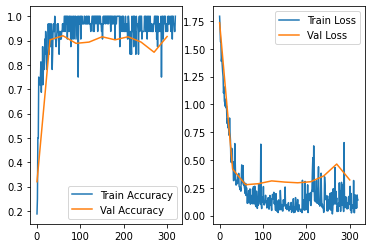

In [ ]:
train(start_frozen=False, model_unfreeze=0)

### 1.4 Implement Unfreezing (1 hr)

#### Description

Unfreezing is a technique that can be helpful when fine tuning a CNN for a more difficult task with a large amount of data.

The idea is that if we allow the network to tweak the earliest layers immediately, before the last FCL has been trained at all, the earliest layers will forget all of the useful features that they learned in order  to provide features that are helpful for the (untrained) FCL.

So, rather than training all of the model weights at once, we learn the last fully connected layer, then train that layer together with the second-to-last layer, gradually adding layers until we reach the first layer.

#### TODO:

- Modify your model class by setting the `requires_grad` attribute of the ResNet to `False`. (but keep `requires_grad = True` for the last layer).
- Add a member function to you model class that allows the user to unfreeze weights in the training loop. See [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) for reference.
- Modify your training loop to add logic that calls the `unfreeze` function of the model class (unfreeze one layer every epoch).
- Call your train function to fine-tune the ResNet on your dataset.

#### Call your train function

train loss:0.3515, train accuracy:0.7500.: 100%|██████████| 320/320 [00:55<00:00,  5.79it/s]


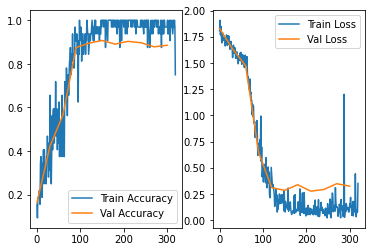

In [ ]:
############################
# train with unfreezing here (should be a single call to your train function)
############################

train(start_frozen=True, model_unfreeze=5)

You may not see any improvement for your classification task, but unfreezing can help convergence for more difficult image classification tasks.

##2 Fine-tune a language model - (15 min)

In this section you will use the gpt-2-simple package [here](https://github.com/minimaxir/gpt-2-simple) to fine-tune the GPT-2 language model on a domain of your choice.

### 2.1 Generate text from the pretrained GPT-2 model

#### Run this code to generate text from a pretrained model

In [ ]:
!pip install gpt-2-simple

# the transformers package is built on top of Tensorflow, and the default TF version 
# for Colab will soon switch to 2.x. We remedy this with the following magic method
# %tensorflow_version 1.x 

import gpt_2_simple as gpt2
import os
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gpt-2-simple: filename=gpt_2_simple-0.8.1-py3-none-any.whl size=24576 sha256=eb13ef24fa8f400a944999d7b1f2bae2ff06dda51e4f25bbeacba794e8ef0e25
  Stored in directory: /root/.cache/pip/wheels/4e/28/f0/2f12e470be10d6804b193e4193d274c88995010fae512a67cf
Successfully built gpt-2-simple


In [ ]:
# This line is necessary to be able to run a new tf session
tf.compat.v1.reset_default_graph()
# The medium-sized model. IF you run out of memory, try "124M" instead
model_name = "124M"
if not os.path.isdir(os.path.join("models", model_name)):
	print(f"Downloading {model_name} model...")
	gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/124M/

sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, model_name=model_name)
gpt2.generate(sess, model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 462Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 4.93Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 548Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:11, 44.8Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 590Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 6.55Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 6.56Mit/s]


Loading pretrained model models/124M/model.ckpt
H.R. 4590 (113th) was a bill in the United States Congress.

A bill must be passed by both the House and Senate in identical form and then be signed by the President to become law.

This bill was introduced in the 113th Congress, which met from Jan 3, 2013 to Jan 2, 2015. Legislation not enacted by the end of a Congress is cleared from the books.

How to cite this information.

We recommend the following MLA-formatted citation when using the information you see here in academic work:

GovTrack.us. (2018). H.R. 4590 — 113th Congress: S. 3431 Congressional Gold Medal Act of 2013. Retrieved from https://www.govtrack.us/congress/bills/113/hr3431?utm_campaign=govtrack_feed&utm_source=govtrack/feed&utm_medium=rss "H.R. 4590 — 113th Congress: S. 3431 Congressional Gold Medal Act of 2013." www.GovTrack.us. 2013. September 29, 2018 <https://www.govtrack.us/congress/bills/113/hr3431?utm_campaign=govtrack_feed&utm_source=govtrack/feed&utm_medium=rss

### 2.2 Download a text dataset

#### TODO:

- Use the provided functions to download your own text dataset
- [Project Gutenberg](https://www.gutenberg.org/) is a nice starting point for raw text corpora

#### Download Dataset

In [ ]:
import zipfile
import os
from torchvision import datasets

def extract_zip(zip_path, remove_finished=True):
    print('Extracting {}'.format(zip_path))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path.replace('.zip', ''))
    if remove_finished:
        os.remove(zip_path)

def download_dataset(url, root='../data/data2'):
    if not os.path.exists(os.path.join(root, 'text')):
        os.makedirs(os.path.join(root))
        datasets.utils.download_url(url, root, 'text.zip', None)
        extract_zip(os.path.join(root, 'text.zip'))
    return os.path.join(root, 'text')

##########################################
# Set the url for your dataset here,
# move the dataset to the desired location
##########################################
url = 'https://www.gutenberg.org/files/1400/1400-0.zip'
download_dataset(url)
# !mv /data/text/30.txt /data/text/bible.txt
!mv /data/data2/text/1400-0.txt /data/data2/text/great_expectations.txt
!ls ../data/data2/text

great_expectations.txt


### 2.3 Fine-tune GPT-2 on your own dataset

#### TODO:

- Swap out the dataset parameter with the path to your dataset

#### Train on your dataset

In [ ]:
# This line is necessary to be able to run a new tf session if one has already been run
tf.compat.v1.reset_default_graph()
# Start a session
sess = gpt2.start_tf_sess()
# Fine tune `model_name` on `data`
###################################
# Swap out the `dataset` parameter with the path to your text dataset
###################################
gpt2.finetune(sess,
              dataset='../data/data2/text/great_expectations.txt',
              model_name=model_name,
              restore_from='latest',
              steps=300)   # steps is max number of training steps

gpt2.generate(sess, run_name='run1')

Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


dataset has 283658 tokens
Training...
[1 | 5.33] loss=3.34 avg=3.34
[2 | 5.66] loss=3.61 avg=3.48
[3 | 5.99] loss=3.27 avg=3.41
[4 | 6.32] loss=3.33 avg=3.39
[5 | 6.64] loss=3.25 avg=3.36
[6 | 6.97] loss=3.32 avg=3.35
[7 | 7.30] loss=3.17 avg=3.33
[8 | 7.62] loss=3.34 avg=3.33
[9 | 7.94] loss=3.20 avg=3.31
[10 | 8.27] loss=3.10 avg=3.29
[11 | 8.60] loss=2.89 avg=3.25
[12 | 8.92] loss=3.31 avg=3.26
[13 | 9.25] loss=3.28 avg=3.26
[14 | 9.58] loss=2.90 avg=3.23
[15 | 9.90] loss=3.35 avg=3.24
[16 | 10.24] loss=3.25 avg=3.24
[17 | 10.56] loss=3.33 avg=3.25
[18 | 10.89] loss=3.09 avg=3.24
[19 | 11.22] loss=3.14 avg=3.23
[20 | 11.54] loss=2.89 avg=3.21
[21 | 11.86] loss=3.32 avg=3.22
[22 | 12.19] loss=3.09 avg=3.21
[23 | 12.51] loss=3.17 avg=3.21
[24 | 12.84] loss=3.15 avg=3.21
[25 | 13.17] loss=3.01 avg=3.20
[26 | 13.50] loss=2.87 avg=3.18
[27 | 13.82] loss=3.01 avg=3.18
[28 | 14.15] loss=3.16 avg=3.18
[29 | 14.48] loss=3.11 avg=3.17
[30 | 14.81] loss=2.86 avg=3.16
[31 | 15.13] loss=3.12 avg